In [1]:
from dataloader import *
from model import *
from train_eval_test import *
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import pandas as pd

2024-01-05 14:52:27.544210: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-05 14:52:29.180065: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-05 14:52:32.483386: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.6/lib64:/usr/local/cuda-12.2/lib64
2024-01-05 14:52:32.484656: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror:

## Load data

In [2]:
traffic_data = pd.read_csv('data/traffic.csv', header=None).to_numpy()

In [3]:
batch_size = 32
n_train = 12185
n_eval = 1757
n_test = 3509
train_loader, eval_loader, test_loader = get_loaders(traffic_data, batch_size, n_train, n_eval, n_test, T=96, S=96)

## Train 

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
writer = SummaryWriter()

cuda


In [5]:
N = 862 #nb variables
T = 96 #input length (lookback window)
D = 512 # 256 ou 512
S = 96 # 96 ou 192, 336, 720
proj_dim = 512
num_blocks = 2 #2 ou 3 ou 4 (nombre de block de transformer)

itransformer = iTransformer(N, T, D, S, proj_dim, num_blocks).to(device)
optimizer = torch.optim.Adam(itransformer.parameters(), lr=1e-4, weight_decay=1e-5) #10−3, 5 × 10−4, 10−4 



In [6]:
loss_values, loss_eval = train(itransformer, optimizer, train_loader, eval_loader, 10, device, writer)

---- epoch :  0
loss train : 0.3259932346343994
loss eval : 0.5152174690548255
---- epoch :  1
loss train : 0.2705346044699351
loss eval : 0.4826001920262162
---- epoch :  2
loss train : 0.25911941719055176
loss eval : 0.4917472290749453
---- epoch :  3
loss train : 0.2548643413384755
loss eval : 0.4733855517543092
---- epoch :  4
loss train : 0.24890527625878653
loss eval : 0.4737469225513692
---- epoch :  5
loss train : 0.2502333790858587
loss eval : 0.4571073687806421
---- epoch :  6
loss train : 0.24527066711584727
loss eval : 0.4567846096291834
---- epoch :  7
loss train : 0.23913382311662038
loss eval : 0.4564372234198512
---- epoch :  8
loss train : 0.23958301337560017
loss eval : 0.46002451558502355
---- epoch :  9
loss train : 0.23727327541510265
loss eval : 0.44711130918288716


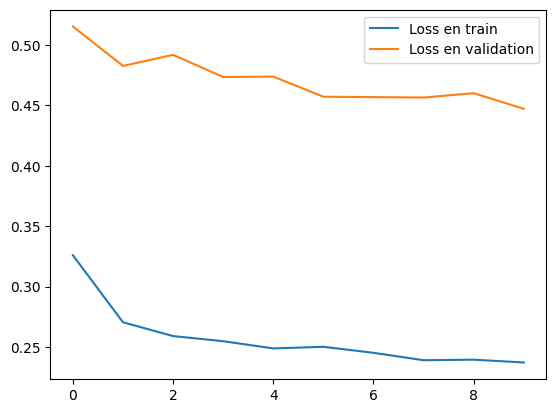

In [7]:
plt.figure()
plt.plot(loss_values,label="Loss en train")
plt.plot(loss_eval,label="Loss en validation")
plt.legend()
plt.show()

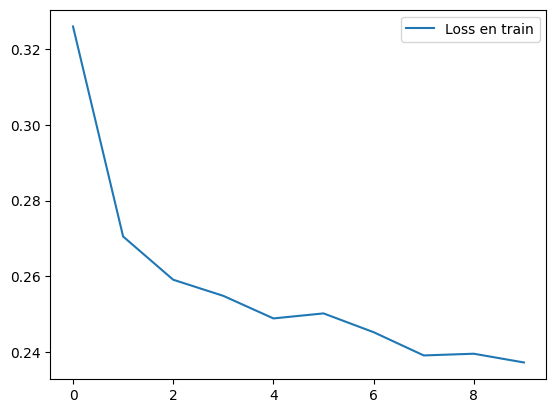

In [8]:
plt.figure()
plt.plot(loss_values,label="Loss en train")
plt.legend()
plt.show()

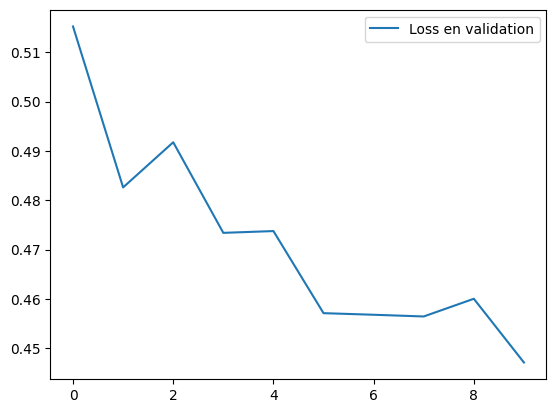

In [9]:
plt.figure()
plt.plot(loss_eval,label="Loss en validation")
plt.legend()
plt.show()

## Test

In [10]:
loss_test, loss_mae, target, yhat = test(itransformer, test_loader, device)
print("MSE : ", loss_test)
print("MAE : ", loss_mae)

MSE :  0.5677742547918074
MAE :  0.3180144213803924


Affichage pour une modalité sur toute la durée de la prédiction

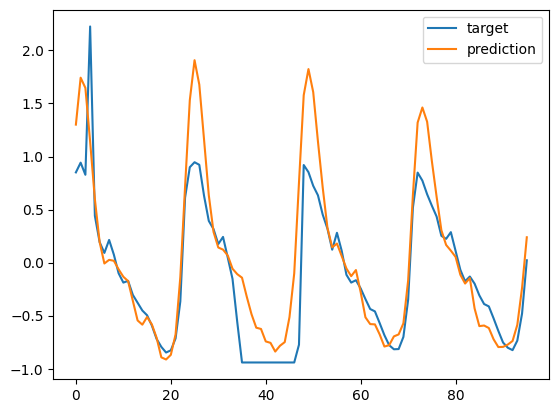

In [11]:
i = 1
plt.figure()
plt.plot(target[0,:,i].to("cpu"),label="target")
plt.plot(yhat[0,:,i].to("cpu"),label="prediction")
plt.legend()
plt.show()

Affichage de toutes les modalités à un instant t

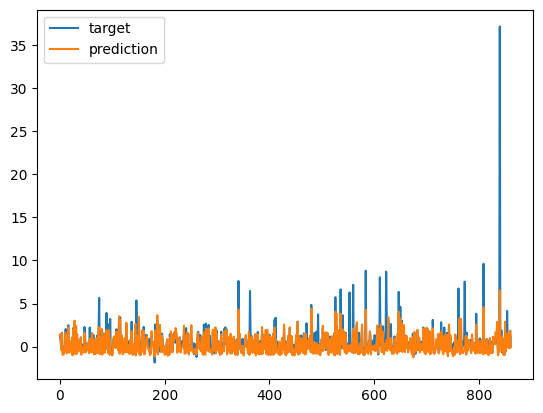

In [12]:
plt.figure()
plt.plot(target[0,0,:].to("cpu"),label="target")
plt.plot(yhat[0,0,:].to("cpu"),label="prediction")
plt.legend()
plt.show()